Aufgaben Linear Networks
========================



## Imports



the common imports:



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

## Linear Regression Network



In the following exercise you should create a linear regression
model from scratch and test it on some synthetically created data:



In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2

n_samples=100
X, y = synthetic_data(true_w, true_b, n_samples)
K = 2

print(f"Training data {X.shape}")

Training data torch.Size([100, 2])


Our goal is to fit a simple regression model with Batch Gradient Descent.
We start with randomly chosen values for the weights and zero bias.
First, implement the function below.



In [4]:
torch.manual_seed(0)
w = torch.normal(0, 0.01, size=(K, 1))
b = torch.zeros(1)

def linreg(X, w, b):
    """The linear regression model.
    
    Parameters:
    X (numpy.ndarray): Input features with shape (m, n), where m is the number of samples and n is the number of features.
    w (numpy.ndarray): Weight vector with shape (n, 1).
    b (float): Bias term.
    
    Returns:
    predictions (numpy.ndarray): Predicted values for each input sample, shape (m, 1).
    """
    return torch.matmul(X, w) + b

Now we need to define the loss functions to be used:



In [5]:
def squared_loss(y_hat, y):
    """
    Calculate the squared loss (mean squared error) between predicted values and actual values.

    Parameters:
    y_hat (numpy.ndarray): Predicted values with shape (m, 1), where m is the number of samples.
    y (numpy.ndarray): Actual target values with shape (m, 1), matching the shape of y_hat.

    Returns:
    loss (float): Mean squared error loss.
    """
    assert y_hat.shape == y.shape
    return 0.5 * ((y_hat - y)**2).sum()

Now we need to implement the training loop for Gradient Descent.
You should not use `autograd` for computing the gradient, instead
build on the closed formula presented in the lecture.



In [6]:
# implementation for the weights (th_1 and th_2)
def gradient_W(y_hat, y):
    return torch.mul((y_hat - y), X).mean(axis=0).reshape(2, 1) # reshape to match w

W=tensor([[ 1.9961],
        [-3.3999]])
b=tensor([4.1973])


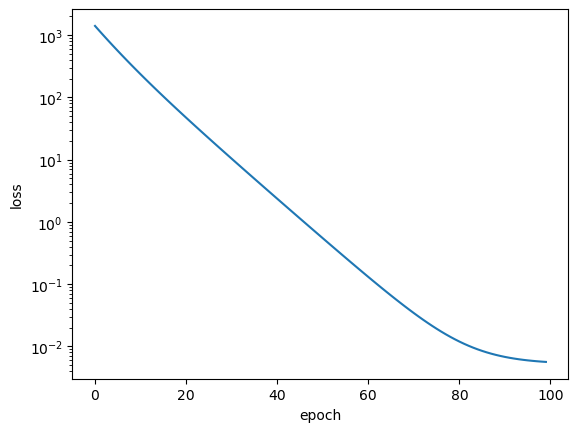

In [7]:
step = 0.1
n_epoch = 100

loss_arr = np.zeros(n_epoch) # to record current loss

for i in range(n_epoch):
    # 1.  Compute the prediction y_hat
    y_hat = linreg(X, w, b)

    # remember the loss for plotting it later
    # loss_arr[i] = squared_loss(y_hat, y)
    loss = squared_loss(y_hat, y)
    loss_arr[i] = loss

    # 2. Use y_hat and y to compute the gradients
    grad_w = torch.mul((y_hat - y), X).mean(axis=0).reshape(K, 1)
    grad_b = (y_hat - y).mean()

    # 3. Update the parameters
    w -= step * grad_w
    b -= step * grad_b

plt.plot(loss_arr)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
print(f"W={w}")
print(f"b={b}")

## Linear networks with autograd



The goal now is to use `autograd` the compute the gradient.
You can use the same skeleton as before



In [9]:
torch.manual_seed(0)
w = torch.normal(0, 0.01, size=(K, 1), requires_grad=True)
b = torch.zeros(1)

step = 0.1
n_epoch = 100

loss_arr = np.zeros(n_epoch) # to record current loss

for i in range(n_epoch):
    pass
    # 1.  Compute the prediction y_hat
    y_hat = linreg(X, w, b)
    loss = squared_loss(y_hat, y)

    # remember the loss for plotting it later
    loss_arr[i] = loss.detach()

    # 2. Use the computed loss to compute the gradients
    # 3. Update the parameters, remember to zero the gradients
    loss.backward()

    with torch.no_grad():
        w -= step * w.grad/n_samples
        b -= step * b.grad/n_samples

        w.grad.zero_()
        b.grad.zero_()

plt.plot(loss_arr)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
print(f"W={w}")
print(f"b={b}")

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Linear classification



We  want to implement a linear network for classification.
We use the famous IRIS data set as an example.



In [10]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y)

This time the network is implemented as a class,
the only thing missing is the implementation of the softmax function,
for example
$$
softmax(y)_1 = \frac{e^{y_1}}{ \sum_{i=1}^3  e^{y_i} }.
$$
You have to implement it below.



In [ ]:
def softmax(y):
    y_exp = torch.exp(y)
    partition = y_exp.sum(axis=1, keepdims=True)
    return y_exp / partition


class SoftmaxNetwork:

    def __init__(self, num_input, num_output, dtype=torch.float64):
        """
        Args:
            num_input: dimension of input space
            num_output: number if output classes
        """
        self.w = torch.randn((num_input,num_output),
                             dtype=dtype).requires_grad_(True)
        self.b = torch.randn(num_output, dtype=dtype).requires_grad_(True)

    def forward(self, X):
        """
        Args:
            X: tensor of shape (n, d)
        """
        y = (X @ self.w + self.b)
        return softmax(y)

Next we have to implement the cross entropy loss, it is already finished:



In [ ]:
def cross_entropy(y_hat, y):
    return (-torch.log(y_hat[range(len(y_hat)), y])).mean()

Note that this implementation does not require a one-hot-encoding for $y$
(but there is one side effect: $y$ has to be of type `torch.int64`!).

The final step is to implement a function that runs the training for us:



In [ ]:
def run_training(net, X, y, f_loss, n_epochs, lr=0.1):
    """ Run the training.
    Args:
       net: an instance of SoftmaxNetwork
       X, y: training data
       f_loss: the loss function
       n_epochs: number of epochs
       lr: the learning rate

    Returns:
      training loss: np.array (loss per epoch)
    """
    train_loss = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        y_hat = net.forward(X)
        l = f_loss(y_hat, y)
        l.backward()

        with torch.no_grad():
            net.w -= lr*net.w.grad
            net.b -= lr*net.b.grad
            net.w.grad.zero_()
            net.b.grad.zero_()

            y_hat = 

Now train the model, don't forget to cast X and y to Pytorch tensors.



In [ ]:
# TODO: cast X and y

net = SoftmaxNetwork(4,3)
train_loss = run_training(net, X, y,  cross_entropy, n_epochs=100, lr=0.2)

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve');

1.  Run the training several times, and observe the different learning curves.
2.  Try the same with a lower learning rate, say $lr=0.05$. Do you see any differences?

Finally check the accuracy of the model, that is the fraction of correctly predicted examples.
Of course this is on training only. If you like you can try to split the
data into train and test and evaluate your network on the test data set.
A useful function for this is `train_test_split` found in `sklearn.model_selection`.

